In [1]:
# path_pysster = "../datasets/2023-05-24_benchmark_results/cross_predictions_ENCODE_CT_tracked_celltype/results.cross-RBP-Prediction.Pysster.csv.gz"
path_pysster = "../datasets/2023-05-24_benchmark_results/crossCT.tracked_CT/results.Pysster.csv.gz"
path_prismnet = "../datasets/2023-05-24_benchmark_results/crossCT.tracked_CT/results.PRISMNet.csv.gz"
path_output_dir = "cross_celltypes.additional_neg2_celltype_separation.pysster_prismnet"

export = True


# Forewords

Additional evaluation of Pysster and PrismNet to address the question : 
"did the models learn any cell-type specific signal that could explain the drop in performance in cross-cell-type application?"



We test this focusing on models trained on the ENCODE eCLIP, where models for an RBP are available for both HepG2 and K562.

- focusing only on negative-2 binding sites predictions scores, **monitoring the cell-type source of the binding site**
- for a given RBP, with a model trained on one celltype:
- can we see differences in prediction scores between negative-2 from the same-celltype vs negative-2 from the other cell-type.

# Imports

In [2]:
import os
import sys
from pathlib import Path

import pandas as pd
import polars as pl
import numpy as np
import yaml
import scipy.stats

from dotmap import DotMap


path = "../code/"
if not str(path) in sys.path:
    sys.path.insert(0, str(path))

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
from plotting_config import *

%run "../code/plotting_config.py"
%run "../code/figure_layouts.py"

/home/lambertmoy/projects/Benchmark-RBP/analyses/code/figure_layouts.py:99: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


# Set-up

In [30]:
if not Path(path_output_dir).exists():
    Path(path_output_dir).mkdir(parents=True, exist_ok=True)

# Load

In [3]:
data = DotMap()

In [4]:
columns = [
    "model",
    "dataset",
    "RBP_dataset",
    "fold",
    "model_negativeset",
    "sample",
    "prediction",
    "true_class",
]


In [5]:
def read_cross_ct_tracked(path):
    df = pd.read_csv(path, header=None, index_col=None, sep=",", names=columns)
    df["sample_source_ct"] = (
        df["sample"].str.split("_", expand=True).iloc[:, 1].rename("sample_source_ct")
    )
    df["model_source_ct"] = (
        df["RBP_dataset"].str.split("_", expand=True).iloc[:, 1].rename("model_source_ct")
    )
    return df


In [6]:
df = read_cross_ct_tracked(path_pysster)
data['pysster'] = df

#df = read_cross_ct_tracked(path_prismnet)
#data['prismnet'] = df


In [7]:
display(df.head(3))


,model,dataset,RBP_dataset,fold,model_negativeset,sample,prediction,true_class,sample_source_ct,model_source_ct
0,Pysster,ENCODE,DDX52_K562,0,negative-1,TBRG4_K562_rep01::chr7:92042548-92042948(+),0.038638,negative-2,K562,K562
1,Pysster,ENCODE,DDX52_K562,0,negative-1,HNRNPL_HepG2_rep01::chr6:166824904-166825304(-),0.891167,negative-2,HepG2,K562
2,Pysster,ENCODE,DDX52_K562,0,negative-1,EFTUD2_HepG2_rep02::chr17:82096319-82096719(-),0.915596,negative-2,HepG2,K562


In [9]:
# We are considering here only negative-2 samples, i.e. each row is a model scoring
# a binding site from *another* RBP. Since we monitor the cell-type source of that
# binding site, we can test whether a model trained on HepG2 scores better HepG2 samples,
# irrespective of the RBP.
display(df["true_class"].unique())


array(['negative-2'], dtype=object)

In [10]:
# But both negative-1 model and negative-2 models are in there ("negative-2" model will have seen positive sites that may come from either cell-types.)
df["model_negativeset"].unique()


array(['negative-1', 'negative-2'], dtype=object)

In [22]:
scipy.stats.ranksums(
    x=df.loc[
        lambda df: (df["model_source_ct"] == "HepG2")
        & (df["sample_source_ct"] == "K562"),
        "prediction",
    ].values,
    y=df.loc[
        lambda df: (df["model_source_ct"] == "HepG2")
        & (df["sample_source_ct"] == "HepG2"),
        "prediction",
    ].values,
    alternative="two-sided",
)


RanksumsResult(statistic=-8.62203365714309, pvalue=6.5775364591835885e-18)

In [23]:
scipy.stats.ranksums(
    x=df.loc[
        lambda df: (df["model_source_ct"] == "K562")
        & (df["sample_source_ct"] == "K562"),
        "prediction",
    ].values,
    y=df.loc[
        lambda df: (df["model_source_ct"] == "K562")
        & (df["sample_source_ct"] == "HepG2"),
        "prediction",
    ].values,
    alternative="two-sided",
)


RanksumsResult(statistic=-14.952425713313627, pvalue=1.5017762473886903e-50)

,model,dataset,RBP_dataset,fold,model_negativeset,sample,prediction,true_class,sample_source_ct,model_source_ct,model_source
0,Pysster,ENCODE,RBFOX2_HepG2,0,negative-2,UPF1_K562_rep01::chr5:176527052-176527452(-),0.047259,negative-2,K562,HepG2,HepG2;negative-2
1,Pysster,ENCODE,RBFOX2_HepG2,0,negative-2,HNRNPC_K562_rep01::chr6:85633233-85633633(-),0.000202,negative-2,K562,HepG2,HepG2;negative-2
2,Pysster,ENCODE,RBFOX2_HepG2,0,negative-2,FUS_K562_rep01::chr1:30907320-30907720(-),0.973701,negative-2,K562,HepG2,HepG2;negative-2
3,Pysster,ENCODE,RBFOX2_HepG2,0,negative-2,AQR_HepG2_rep01::chr8:140549127-140549527(-),0.020841,negative-2,HepG2,HepG2,HepG2;negative-2
4,Pysster,ENCODE,RBFOX2_HepG2,0,negative-2,AGGF1_HepG2_rep02::chr12:117150655-117151055(-),0.978637,negative-2,HepG2,HepG2,HepG2;negative-2
...,...,...,...,...,...,...,...,...,...,...,...
1195345,Pysster,ENCODE,SBDS_K562,0,negative-2,SAFB_HepG2_rep02::chr17:55289752-55290152(+),0.489138,negative-2,HepG2,K562,K562;negative-2
1195346,Pysster,ENCODE,SBDS_K562,0,negative-2,TIAL1_HepG2_rep01::chr8:8339672-8340072(-),0.491532,negative-2,HepG2,K562,K562;negative-2
1195347,Pysster,ENCODE,SBDS_K562,0,negative-2,SUB1_HepG2_rep02::chr9:130878285-130878685(+),0.489757,negative-2,HepG2,K562,K562;negative-2
1195348,Pysster,ENCODE,SBDS_K562,0,negative-2,CDC40_HepG2_rep02::chrX:154762811-154763211(+),0.497743,negative-2,HepG2,K562,K562;negative-2


In [44]:
def effect_size(df):
    display(
        df.assign(
            model_source_ct_neg=lambda df: df["model_source_ct"] + ";" + df["model_negativeset"]
        ).groupby("model_source_ct_neg").apply(
            lambda g: g.loc[g["sample_source_ct"] == "HepG2", "prediction"].mean()
            - g.loc[g["sample_source_ct"] == "K562", "prediction"].mean()
        )
    )



In [45]:
effect_size(data['pysster'])

model_source_ct_neg
HepG2;negative-1    0.008456
HepG2;negative-2    0.001560
K562;negative-1     0.016321
K562;negative-2     0.008529
dtype: float64

In [46]:
effect_size(data['prismnet'])

model_source_ct_neg
HepG2;negative-2    0.276238
K562;negative-2    -0.294923
dtype: float64

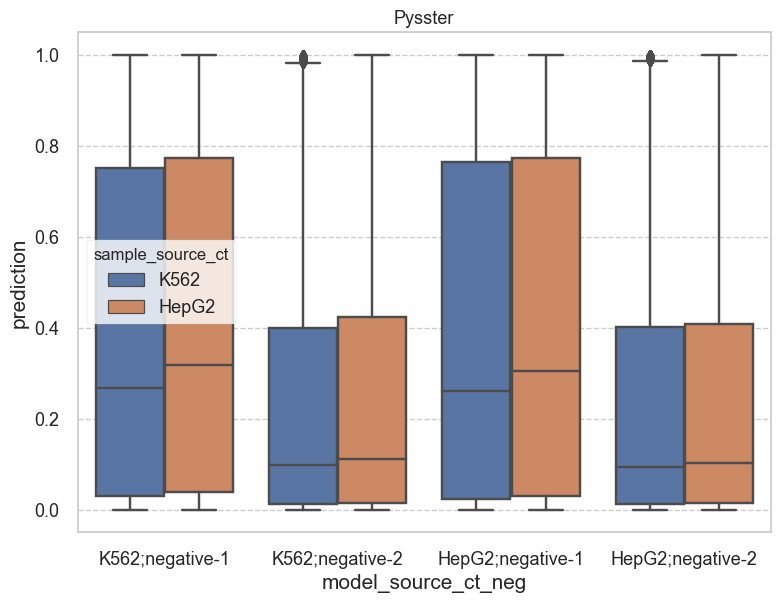

In [11]:

fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(1,1,1)

sns.boxplot(
    data=data['pysster'].loc[lambda df: df['true_class']=='negative-2'].assign(
        model_source_ct_neg=lambda df: df["model_source_ct"]
        + ";"
        + df["model_negativeset"]
    ),
    hue="sample_source_ct",
    x="model_source_ct_neg",
    y="prediction",
    ax=ax1,
)

plt.tight_layout()
ax1.set_title("Pysster")
plt.show()


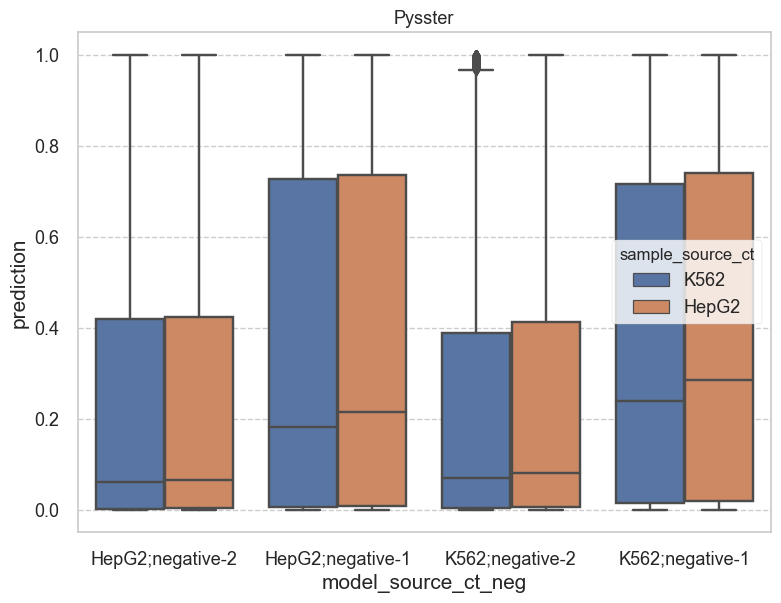

In [53]:
fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(1,1,1)

sns.boxplot(
    data=data['pysster'].loc[lambda df: df['true_class']=='negative-2'].assign(
        model_source_ct_neg=lambda df: df["model_source_ct"]
        + ";"
        + df["model_negativeset"]
    ),
    hue="sample_source_ct",
    x="model_source_ct_neg",
    y="prediction",
    ax=ax1,
)

plt.tight_layout()
ax1.set_title("Pysster")
plt.show()


In [47]:
data['prismnet'].head(3)

,model,dataset,RBP_dataset,fold,model_negativeset,sample,prediction,true_class,sample_source_ct,model_source_ct
0,PRISMNet,ENCODE,UPF1_K562,0,negative-2,AGGF1_K562_rep01::chr21:32584823-32584924(-),0.081153,negative-2,K562,K562
1,PRISMNet,ENCODE,UPF1_K562,0,negative-2,SFPQ_HepG2_rep02::chr2:177264311-177264412(-),0.775177,negative-2,HepG2,K562
2,PRISMNet,ENCODE,UPF1_K562,0,negative-2,TRA2A_HepG2_rep01::chr7:74728735-74728836(+),0.143384,negative-2,HepG2,K562


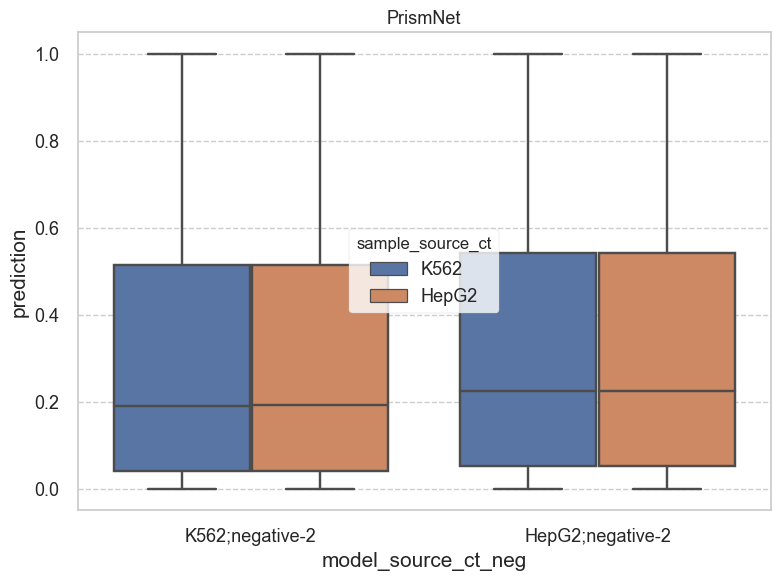

In [50]:
fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(1, 1, 1)

sns.boxplot(
    data=data["prismnet"]
    .loc[lambda df: df["true_class"] == "negative-2"]
    .assign(
        model_source_ct_neg=lambda df: df["model_source_ct"]
        + ";"
        + df["model_negativeset"]
    ),
    hue="sample_source_ct",
    x="model_source_ct_neg",
    y="prediction",
    ax=ax1,
)

ax1.set_title("PrismNet")
plt.tight_layout()
plt.show()


<AxesSubplot:xlabel='model_source_ct', ylabel='prediction'>

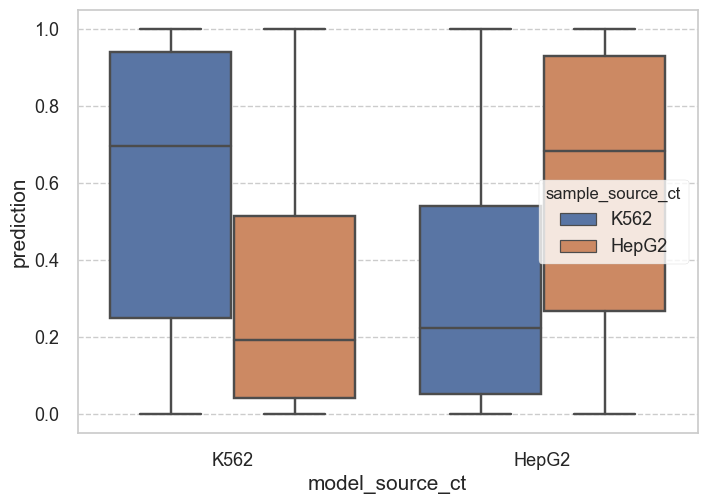

: 

In [54]:
sns.boxplot(
    data=df.loc[lambda df: (df["model_negativeset"] == "negative-2"), :],
    hue="sample_source_ct",
    x="model_source_ct",
    y="prediction",
)
